In [8]:
#Install required packages
#pip install beautifulsoup4

In [ ]:
#Install required packages
!conda install -c conda-forge geopy 

In [1]:
#Install required packages
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.8           |   py36h45558ae_2         628 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    pandas-1.0.3               |   py36h830a2c2_1        11.1 MB  conda-

In [6]:
#Import packages
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


In [ ]:
#set connection details
CLIENT_ID='ZZXDCXSHV4AN3RGUUES3AXCB2CKGVLY4Z2MKY3NOUY4MQGJN'
CLIENT_SECRET = 'FR4AP41YKVKJYRHH4R2NF02QJRQRYW52USXJSP1224L2DY3P'
radius=50
LIMIT=100
VERSION = '20180604'

In [3]:
#define procs to get the location data
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
#vaildate data
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
#check data shape
ny_data.shape

(306, 4)

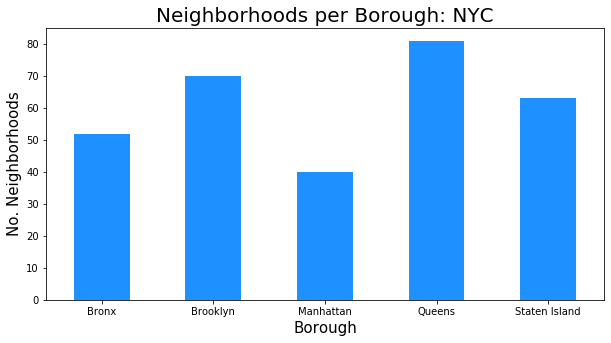

In [6]:
#illustrate data
clr = "dodgerblue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [7]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(ny_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    print(row)
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

In [8]:
#save copy to review, analyze data
indian_rest_ny.to_csv('indian_rest_ny_tocsv1.csv') 

In [9]:
#read and validate
indian_rest_ny = pd.read_csv('indian_rest_ny_tocsv1.csv')
indian_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
30,30,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant
31,31,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine
32,32,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux
33,33,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen (Indikitch)
34,34,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden


In [29]:
#validate data shape
indian_rest_ny.shape

(35, 5)

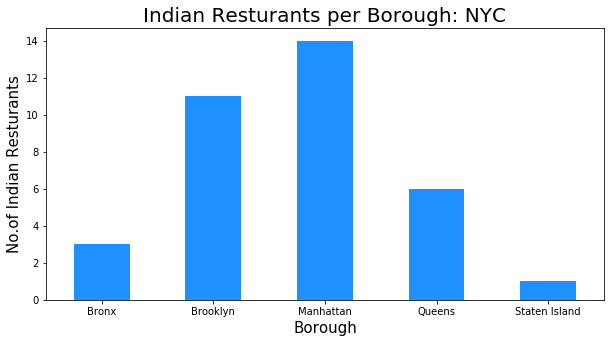

In [30]:
#illustrate data
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Indian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

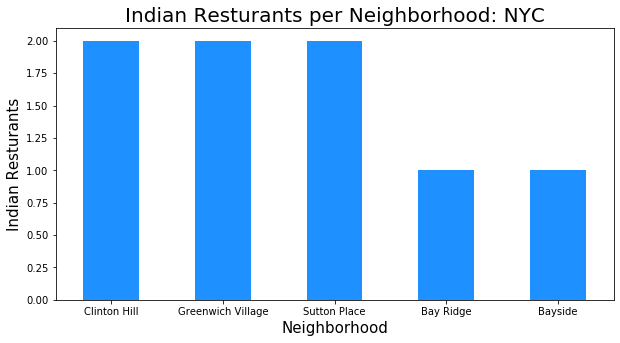

In [31]:
NOofNeigh = 5
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Indian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Indian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [28]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Clinton Hill']

,Unnamed: 0,Borough,Neighborhood,ID,Name
9,9,Brooklyn,Clinton Hill,568d3902498e619efcbc3f58,Spice & Grill
10,10,Brooklyn,Clinton Hill,4ace7c86f964a520d3d020e3,Kinara's


In [32]:
indian_rest_ny.values.tolist()

[[0, 'Bronx', 'Woodlawn', '4c0448d9310fc9b6bf1dc761', 'Curry Spot'],
 [1,
  'Bronx',
  'Parkchester',
  '55dfa36a498e164ef19bef7b',
  'Premium Sweets & Restaurant'],
 [2,
  'Bronx',
  'Unionport',
  '4c194631838020a13e78e561',
  'Melanies Roti Bar And Grill'],
 [3, 'Brooklyn', 'Bay Ridge', '545835a1498e820edc6f636f', 'Bombay Grill'],
 [4, 'Brooklyn', 'Greenpoint', '51a5445c498ee0f182370cb2', 'Agra Taj Mahal'],
 [5, 'Brooklyn', 'Bushwick', '5169f5c4e4b0c7fcb77a0f3c', 'Agra Heights'],
 [6,
  'Brooklyn',
  'Brooklyn Heights',
  '4b8ffc16f964a520246e33e3',
  'Curry Heights'],
 [7,
  'Brooklyn',
  'Gowanus',
  '52f18573498ec2c34e830ffd',
  "Kanan's Indian Restaurant"],
 [8, 'Brooklyn', 'Fort Greene', '57596dad498e732300496b23', 'Dosa Royale'],
 [9, 'Brooklyn', 'Clinton Hill', '568d3902498e619efcbc3f58', 'Spice & Grill'],
 [10, 'Brooklyn', 'Clinton Hill', '4ace7c86f964a520d3d020e3', "Kinara's"],
 [11, 'Brooklyn', 'Boerum Hill', '543870ec498ec64de510608d', 'Masala Grill'],
 [12,
  'Brooklyn',

In [35]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in indian_rest_ny.values.tolist():
    Index,Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5e93bb4b618f43001b2bc881'}, 'response': {'venue': {'id': '4c0448d9310fc9b6bf1dc761', 'name': 'Curry Spot', 'contact': {'phone': '7187085900', 'formattedPhone': '(718) 708-5900'}, 'location': {'address': '4268 Katonah Ave', 'crossStreet': 'E 235 Street', 'lat': 40.897624941880906, 'lng': -73.86714729157393, 'labeledLatLngs': [{'label': 'display', 'lat': 40.897624941880906, 'lng': -73.86714729157393}, {'label': '?', 'lat': 40.897709, 'lng': -73.86707}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4268 Katonah Ave (E 235 Street)', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/curry-spot/4c0448d9310fc9b6bf1dc761', 'categories': [{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primar

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
30,Queens,Jamaica Hills,4c434b2bd691c9b6ef8f8f0a,Sagar Restaurant,10,7.3,6
31,Manhattan,Sutton Place,4a63bfb4f964a520b3c51fe3,Chola Eclectic Indian Cuisine,155,8.4,58
32,Manhattan,Sutton Place,4fe4fb50c2eee335e4fea69d,Moti Mahal Delux,186,8.4,83
33,Manhattan,Flatiron,52a1fa08498ede15b1530912,Deep Indian Kitchen (Indikitch),682,8.4,133
34,Queens,Sunnyside Gardens,4c48da9f3013a59356c5f0e1,Saffron Garden,17,7.6,16


In [36]:
#save the data
indian_rest_stats_ny.to_csv('indian_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [37]:
#check data shape
indian_rest_stats_ny.shape

(35, 7)

In [38]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       35 non-null     object 
 1   Neighborhood  35 non-null     object 
 2   ID            35 non-null     object 
 3   Name          35 non-null     object 
 4   Likes         35 non-null     object 
 5   Rating        35 non-null     float64
 6   Tips          35 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.0+ KB


In [39]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       35 non-null     object 
 1   Neighborhood  35 non-null     object 
 2   ID            35 non-null     object 
 3   Name          35 non-null     object 
 4   Likes         35 non-null     float64
 5   Rating        35 non-null     float64
 6   Tips          35 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.0+ KB


In [40]:
#describe df
indian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,35.0000,35.000000,35.000000
mean,87.2000,7.508571,28.428571
std,149.3127,1.571693,36.832918
min,0.0000,0.000000,0.000000
25%,14.0000,7.300000,9.000000
50%,34.0000,7.700000,16.000000
75%,81.0000,8.400000,26.000000
max,682.0000,9.100000,148.000000


In [41]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                               Manhattan
Neighborhood                           Flatiron
ID                     52a1fa08498ede15b1530912
Name            Deep Indian Kitchen (Indikitch)
Likes                                       682
Rating                                      8.4
Tips                                        133
Name: 33, dtype: object

In [42]:
# Resturant with maximum Ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 20, dtype: object

In [43]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 20, dtype: object

In [44]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
26,Tribeca,9.1
19,Noho,8.8
8,Fort Greene,8.7
11,Greenwich Village,8.6
22,Prospect Lefferts Gardens,8.6
29,West Village,8.5
20,North Side,8.5
25,Sutton Place,8.4
7,Flatiron,8.4
1,Bayside,8.2


In [45]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.207143
4,Staten Island,8.100000
1,Brooklyn,7.400000
3,Queens,7.350000
0,Bronx,4.766667


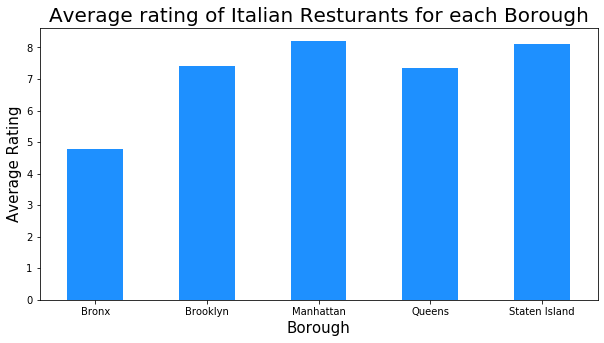

In [46]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Italian Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [47]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Bayside,8.2
5,Civic Center,8.2
7,Flatiron,8.4
8,Fort Greene,8.7
11,Greenwich Village,8.6
18,New Dorp,8.1
19,Noho,8.8
20,North Side,8.5
22,Prospect Lefferts Gardens,8.6
25,Sutton Place,8.4


In [48]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bayside,40.766041,-73.774274,8.2
1,Manhattan,Civic Center,40.715229,-74.005415,8.2
2,Manhattan,Flatiron,40.739673,-73.990947,8.4
3,Brooklyn,Fort Greene,40.688527,-73.972906,8.7
4,Manhattan,Greenwich Village,40.726933,-73.999914,8.6
5,Staten Island,New Dorp,40.572572,-74.116479,8.1
6,Manhattan,Noho,40.723259,-73.988434,8.8
7,Brooklyn,North Side,40.714823,-73.958809,8.5
8,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,8.6
9,Manhattan,Sutton Place,40.760280,-73.963556,8.4


In [7]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [50]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [187]:
#validate the data
print(ny_neighborhood_stats)

#encoding the borough
ny_neighborhood_stats_onehot = pd.get_dummies(ny_neighborhood_stats[['Borough']], prefix="", prefix_sep="")
ny_neighborhood_stats_onehot['Borough'] = ny_neighborhood_stats['Borough'] 
ny_neighborhood_stats_onehot['Average Rating'] = ny_neighborhood_stats['Average Rating'] 
ny_neighborhood_stats_onehot['Latitude'] = ny_neighborhood_stats['Latitude'] 
ny_neighborhood_stats_onehot['Longitude'] = ny_neighborhood_stats['Longitude'] 
#add the other elements back to the encoded data
ny_neighborhood_stats_onehot
#ny_neighborhood_stats_clustering = ny_neighborhood_stats.drop('Cluster_Labels', 1)
#ny_neighborhood_stats_clustering

          Borough               Neighborhood   Latitude  Longitude  \
0          Queens                    Bayside  40.766041 -73.774274   
1       Manhattan               Civic Center  40.715229 -74.005415   
2       Manhattan                   Flatiron  40.739673 -73.990947   
3        Brooklyn                Fort Greene  40.688527 -73.972906   
4       Manhattan          Greenwich Village  40.726933 -73.999914   
5   Staten Island                   New Dorp  40.572572 -74.116479   
6       Manhattan                       Noho  40.723259 -73.988434   
7        Brooklyn                 North Side  40.714823 -73.958809   
8        Brooklyn  Prospect Lefferts Gardens  40.658420 -73.954899   
9       Manhattan               Sutton Place  40.760280 -73.963556   
10      Manhattan                    Tribeca  40.721522 -74.010683   
11      Manhattan               West Village  40.734434 -74.006180   
12          Bronx                   Woodlawn  40.898273 -73.867315   

    Average Rating 

,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Borough,Average Rating,Latitude,Longitude
0,0,0,0,1,0,Queens,8.2,40.766041,-73.774274
1,0,0,1,0,0,Manhattan,8.2,40.715229,-74.005415
2,0,0,1,0,0,Manhattan,8.4,40.739673,-73.990947
3,0,1,0,0,0,Brooklyn,8.7,40.688527,-73.972906
4,0,0,1,0,0,Manhattan,8.6,40.726933,-73.999914
5,0,0,0,0,1,Staten Island,8.1,40.572572,-74.116479
6,0,0,1,0,0,Manhattan,8.8,40.723259,-73.988434
7,0,1,0,0,0,Brooklyn,8.5,40.714823,-73.958809
8,0,1,0,0,0,Brooklyn,8.6,40.658420,-73.954899
9,0,0,1,0,0,Manhattan,8.4,40.760280,-73.963556


In [188]:
from sklearn.cluster import KMeans
#Cluster Neighborhoods
# set number of clusters
kclusters = 6

#ny_neighborhood_stats_clustering = ny_neighborhood_stats_onehot.drop('Label', 1)
#ny_neighborhood_stats_clustering = ny_neighborhood_stats_onehot.drop('Neighborhood', 1)
ny_neighborhood_stats_clustering = ny_neighborhood_stats_onehot.drop('Borough', 1)
ny_neighborhood_stats_clustering
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_neighborhood_stats_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 
# to change use .astype()

array([3, 5, 5, 2, 5, 4, 1, 2, 2, 5, 1, 5, 0], dtype=int32)

In [224]:
#ny_neighborhood_stats=ny_neighborhood_stats.drop(['Cluster_Labels'],axis=1)
#ny_neighborhood_stats_clustering
#ny_neighborhood_stats_clustering.insert(0, 'Cluster_Labels', kmeans.labels_)
ny_neighborhood_stats_clustering

,Cluster_Labels,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Average Rating,Latitude,Longitude
0,3,0,0,0,1,0,8.2,40.766041,-73.774274
1,5,0,0,1,0,0,8.2,40.715229,-74.005415
2,5,0,0,1,0,0,8.4,40.739673,-73.990947
3,2,0,1,0,0,0,8.7,40.688527,-73.972906
4,5,0,0,1,0,0,8.6,40.726933,-73.999914
5,4,0,0,0,0,1,8.1,40.572572,-74.116479
6,1,0,0,1,0,0,8.8,40.723259,-73.988434
7,2,0,1,0,0,0,8.5,40.714823,-73.958809
8,2,0,1,0,0,0,8.6,40.658420,-73.954899
9,5,0,0,1,0,0,8.4,40.760280,-73.963556


In [236]:
#Examine cluster

ny_neighborhood_stats_clustering.loc[ny_neighborhood_stats_clustering['Cluster_Labels'] == 0, ny_neighborhood_stats_clustering.columns[[1] + list(range(2, ny_neighborhood_stats_clustering.shape[1]))]]


,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Average Rating,Latitude,Longitude
12,1,0,0,0,0,8.0,40.898273,-73.867315


In [237]:
#Examine cluster

ny_neighborhood_stats_clustering.loc[ny_neighborhood_stats_clustering['Cluster_Labels'] == 1, ny_neighborhood_stats_clustering.columns[[1] + list(range(2, ny_neighborhood_stats_clustering.shape[1]))]]


,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Average Rating,Latitude,Longitude
6,0,0,1,0,0,8.8,40.723259,-73.988434
10,0,0,1,0,0,9.1,40.721522,-74.010683


In [213]:
#Examine cluster

ny_neighborhood_stats_clustering.loc[ny_neighborhood_stats_clustering['Cluster_Labels'] == 2, ny_neighborhood_stats_clustering.columns[[1] + list(range(2, ny_neighborhood_stats_clustering.shape[1]))]]


,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Average Rating,Latitude,Longitude
3,0,1,0,0,0,8.7,40.688527,-73.972906
7,0,1,0,0,0,8.5,40.714823,-73.958809
8,0,1,0,0,0,8.6,40.658420,-73.954899


In [214]:
#Examine cluster

ny_neighborhood_stats_clustering.loc[ny_neighborhood_stats_clustering['Cluster_Labels'] == 3, ny_neighborhood_stats_clustering.columns[[1] + list(range(2, ny_neighborhood_stats_clustering.shape[1]))]]


,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Average Rating,Latitude,Longitude
0,0,0,0,1,0,8.2,40.766041,-73.774274


In [215]:
#Examine cluster

ny_neighborhood_stats_clustering.loc[ny_neighborhood_stats_clustering['Cluster_Labels'] == 4, ny_neighborhood_stats_clustering.columns[[1] + list(range(2, ny_neighborhood_stats_clustering.shape[1]))]]


,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Average Rating,Latitude,Longitude
5,0,0,0,0,1,8.1,40.572572,-74.116479


In [216]:
#Examine cluster

ny_neighborhood_stats_clustering.loc[ny_neighborhood_stats_clustering['Cluster_Labels'] == 5, ny_neighborhood_stats_clustering.columns[[1] + list(range(2, ny_neighborhood_stats_clustering.shape[1]))]]


,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Average Rating,Latitude,Longitude
1,0,0,1,0,0,8.2,40.715229,-74.005415
2,0,0,1,0,0,8.4,40.739673,-73.990947
4,0,0,1,0,0,8.6,40.726933,-73.999914
9,0,0,1,0,0,8.4,40.760280,-73.963556
11,0,0,1,0,0,8.5,40.734434,-74.006180


In [279]:
# create map and display it
#print(ny_neighborhood_stats_clustering)
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
kclusters=6
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


#markers_colors = []
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, cluster in ny_neighborhood_stats_clustering[['Latitude','Longitude', 'Cluster_Labels']].values:
    label = folium.Popup(str(cluster) + ' Cluster ' + str(cluster), parse_html=True)
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color=rainbow[int(cluster-1)],
            fill=True,
            fill_color=rainbow[int(cluster-1)],
            fill_opacity=0.6
        )
    )
    


In [280]:
#ny_neighborhood_stats_clustering['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats_clustering[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)